In [11]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [12]:
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

In [13]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1 = MonotonicLinear(1, 3)
    self.input2 = torch.nn.Linear(4, 3)
    self.output = torch.nn.MaxPool1d(3)

  def forward(self, x_m, x_u):
    z1 = self.input1(x_m)
    z2 = self.input2(x_u)
    z = torch.add(z1, z2)
    z = self.output(z)
    return z

# Create network
device = torch.device("cpu")
net = Net().to(device)

In [14]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_m_data, testset.x_u_data)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST

    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [15]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [16]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tsa_k3 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+3: end+3]
    Tz_k   = np.array(df['room_temp']).reshape(-1,1)[start: end]
    Tz_k1  = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]
    Tz_k2  = np.array(df['room_temp']).reshape(-1,1)[start+2: end+2]
    msa_k3 = np.array(df['airflow_current']).reshape(-1,1)[start+3: end+3]

    tmp_x_u = np.concatenate((Tz_k, Tz_k1, Tz_k2, msa_k3), axis=1)
    tmp_y   = np.array(df['room_temp']).reshape(-1,1)[start+3: end+3]

    self.x_m_data = torch.tensor(Tsa_k3, dtype=torch.float32)
    self.x_u_data = torch.tensor(tmp_x_u, dtype=torch.float32)
    self.y_data   = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.y_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp_m  = self.x_m_data[idx]
    inp_u  = self.x_u_data[idx]
    outp   = self.y_data[idx]
    sample = {'inp_m':inp_m, 'inp_u':inp_u, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train  = 64
train_ds = Data(src_file, start=0,       end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [17]:
def early_stop(r2, patience):
    if(len(r2) > 10000):
        if(np.max(r2[-patience:]) < np.max(r2[0: -patience])):
            return 1
    return 0

In [18]:
def r2(y_true, y_pred):
    SSR = np.sum(np.square(y_pred - y_true))
    SST = np.sum(np.square(y_pred - np.mean(y_true)))
    r2 = 1 - SSR/SST
    return r2

In [19]:
def R2_f():
    df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

    start = 64
    end   = 1600

    msa_3 = np.array(df['airflow_current']).reshape(-1,1)[start+3: end+3]
    Tsa_3 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+3: end+3]
    Tz_0  = np.array(df['room_temp']).reshape(-1,1)[start: end]
    Tz_1  = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]
    Tz_2  = np.array(df['room_temp']).reshape(-1,1)[start+2: end+2]
    Tz_3  = np.array(df['room_temp']).reshape(-1,1)[start+3: end+3]

    Tz0  =  Tz_0[0].reshape(-1,1)
    Tz1  =  Tz_1[0].reshape(-1,1)
    Tz2  =  Tz_2[0].reshape(-1,1)

    # horizon length
    n = 10
    T = np.array([])
    for i in range(n):
        x1 = torch.tensor(np.copy(Tsa_3[i]).reshape(-1,1), dtype=torch.float32)
        x2 = np.concatenate((Tz0, Tz1, Tz2, msa_3[i].reshape(-1,1)), axis=1)
        x2 = torch.tensor(x2, dtype=torch.float32)
        
        with torch.no_grad():
            # COMPUTE
            Tz3 = net(x1, x2)

            # UPDATE
            Tz0 = np.copy(Tz1).reshape(-1,1)
            Tz1 = np.copy(Tz2).reshape(-1,1)
            Tz2 = np.copy(Tz3).reshape(-1,1)

            # save Tz
            T = np.append(T, Tz3)

    return r2(Tz_3[0:n], T)

In [20]:
# train model
max_epochs = 100000
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.02)

R2_train   = np.array([])
RMSE_train = np.array([])
R2_test    = np.array([])
RMSE_test  = np.array([])
R2_full    = np.array([])

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X_m = batch['inp_m']
        X_u = batch['inp_u']
        Y   = batch['outp']

        optimizer.zero_grad()
        output = net(X_m, X_u)             # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2_train   = np.append(R2_train, eval(net, train_ds)[0].item())
    RMSE_train = np.append(RMSE_train, eval(net, train_ds)[1].item())
    R2_test    = np.append(R2_test, eval(net, test_ds)[0].item())
    RMSE_test  = np.append(RMSE_test, eval(net, test_ds)[1].item())
    R2_full  = np.append(R2_full, R2_f())

    if(epoch%1000==0):
        print(
            "epoch = %5d \t loss = %11.3f \t RMSE = %8.3f \t R2 = %8.5f \t Max_R2 = %8.5f \t R2_full = %8.2f \t max_R2_full = %8.2f" % 
        (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item(), np.max(R2_test), R2_f(), np.max(R2_full))
        )

    # if(epoch%1000==0):
    #     print(
    #     "epoch = %5d \t loss = %11.3f \t RMSE = %8.3f \t R2 = %8.5f \t Max_R2 = %8.5f" % 
    # (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item(), np.max(R2_test))
    # )
    
    if(early_stop(R2_test, 500) == 1):
        break

epoch =     0 	 loss =  112474.047 	 RMSE =  308.428 	 R2 =  0.00245 	 Max_R2 =  0.00245 	 R2_full =    -9.00 	 max_R2_full =    -9.00
epoch =  1000 	 loss =       9.251 	 RMSE =    2.755 	 R2 =  0.04059 	 Max_R2 =  0.13352 	 R2_full =    -9.00 	 max_R2_full =    -9.00
epoch =  2000 	 loss =       2.694 	 RMSE =    1.476 	 R2 =  0.46444 	 Max_R2 =  0.46444 	 R2_full =    -9.01 	 max_R2_full =    -9.00
epoch =  3000 	 loss =       1.170 	 RMSE =    0.965 	 R2 =  0.73096 	 Max_R2 =  0.73096 	 R2_full =    -9.02 	 max_R2_full =    -9.00
epoch =  4000 	 loss =       0.603 	 RMSE =    0.677 	 R2 =  0.86740 	 Max_R2 =  0.86740 	 R2_full =    -9.07 	 max_R2_full =    -9.00
epoch =  5000 	 loss =       0.353 	 RMSE =    0.517 	 R2 =  0.92420 	 Max_R2 =  0.92727 	 R2_full =    -9.34 	 max_R2_full =    -9.00
epoch =  6000 	 loss =       0.182 	 RMSE =    0.378 	 R2 =  0.95864 	 Max_R2 =  0.95864 	 R2_full =    -9.21 	 max_R2_full =    -9.00
epoch =  7000 	 loss =       0.106 	 RMSE =    0.293 	 

In [21]:
def plot(dataset, size):
  with torch.no_grad():
      pred_Y = net(dataset.x_m_data, dataset.x_u_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

RMSE: 0.1008489727973938
R2:   0.9932725429534912


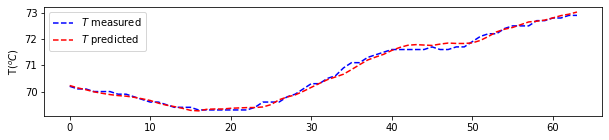

In [22]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (10, 2))

RMSE: 0.153349369764328
R2:   0.9937487244606018


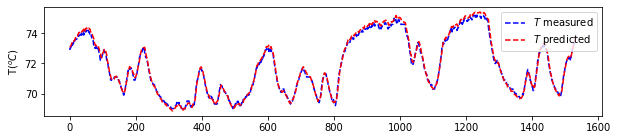

In [23]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ",   eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))

In [24]:
print(np.argmax(R2_test))
print(np.max(R2_test))

15965
0.9950951933860779


In [25]:
# PATH = 'C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tz_3_previous_Tz.pt'
# torch.save(net, PATH)